In [197]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from tensorboardX import SummaryWriter

import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
!! unzip data.zip

['Archive:  data.zip',
 'replace data/nice_embed_tsne.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

In [3]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [4]:
seq_df.iloc[2, :][0]

'MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFVKRNTGKRLPIGKRSNLYVRICDLSGTIYMGETFILESWEELYLPEPTKMEVLGTLESCCGIPPFPEWIVMVGEDQCVYAYGDEEILLFAYSVKQLVEEGIQETGISYKYPDDISDVDEEVLQQDEEIQKIRKKTREFVDKDAQEFQDFLNSLDASLLS'

In [5]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [6]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [7]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [8]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = set(flat_codones)
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [9]:
dictionary = make_dictionary(all_codones)

In [30]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [152]:
BATCH_SIZE = 128
SKIP_WINDOW = 25  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [93]:
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()
        self.embed_centres = torch.nn.Embedding(vocab_size, embed_size, sparse=True)
        self.embed_targets = torch.nn.Embedding(vocab_size, embed_size, sparse=True)
        self.logsigm = torch.nn.LogSigmoid()
        
    def init_weights(self):
        self.embed_centres.weight.data.uniform_(-1.0, 1.0)
        self.embed_targets.weight.data.uniform_(-0, 0)
        
    def forward(self, centres, targets, negs):
        embed_c = self.embed_centres(centres)
        embed_t = self.embed_targets(targets).squeeze()
        fun_pos = torch.sum(embed_t * embed_c, dim=1)
        pos = self.logsigm(fun_pos)
        embed_neg = self.embed_targets(negs)
        fun_neg = torch.bmm(embed_neg, embed_c.unsqueeze(2)).squeeze()
        neg = torch.sum(self.logsigm(fun_neg), dim=1)
        return -(pos + neg).mean()
        
        

In [73]:
def init_gen():
    flat_codones = flatten(all_codones)
    frequency = {}
    for codone in flat_codones:
        if codone not in frequency:
            frequency[codone] = 0
        frequency[codone] += 1
    freq_codones = []
    for key, value in sorted(frequency.items(), key=lambda kv: kv[1]):
        if value < 10000:
            freq_codones.append(dictionary[key])
        else: break
    return freq_codones
  
freq = init_gen()

def gen_neg(batch_size, num_neg_s):
    neg_samples = np.zeros((batch_size, num_neg_s))
    for i in range(batch_size):
        samples = random.sample(freq, num_neg_s)
        neg_samples[i] = samples
    return neg_samples

In [157]:
learning_rate = 0.2
epoch = 100000
num_neg_s = 10
skip_step = 5000
vocab_size = len(dictionary)
embed_size = 100

In [158]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SkipGram(vocab_size, embed_size)
model.init_weights()
model.to(device)

SkipGram(
  (embed_centres): Embedding(9424, 100, sparse=True)
  (embed_targets): Embedding(9424, 100, sparse=True)
  (logsigm): LogSigmoid()
)

In [172]:
def train():
    make_dir('checkpoints')
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    total_loss = 0.0

    for i in range(epoch):
        centers, targets = next(batch_gen)
    #     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        neg_samples = gen_neg(BATCH_SIZE, num_neg_s)
    #     learning_rate *= 0.9999
    #     t = data.to(device)
        loss = model(torch.cuda.LongTensor(centers), torch.cuda.LongTensor(targets), torch.cuda.LongTensor(neg_samples))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (i + 1) % skip_step == 0:
            print(i+1, total_loss / skip_step)
            total_loss = 0.0
            torch.save(model.state_dict(), 'checkpoints/model_step%d.pt' % (i + 1))
    return model.embed_centres.weight.data

In [185]:
res_weights = train()

5000 0.0019119893507857342
10000 0.0035438465190003625
15000 0.003338534102658741
20000 0.0030809274969738907
25000 0.003177003545348998
30000 0.0037038181231851923
35000 0.001955374738748651
40000 0.002748036107583903
45000 0.0042247966842842285
50000 0.003154821853910107
55000 0.002612305338779697
60000 0.0023218347224697937
65000 0.003317257557093399
70000 0.0033457096866564826
75000 0.0025862615462276155
80000 0.002083654931309866
85000 0.002517868377827108
90000 0.002976724913527141
95000 0.0015825858758500544
100000 0.0024732875821500784


In [186]:
tsne = TSNE(n_components=2, random_state=100)
XX = tsne.fit_transform(res_weights.cpu().data.numpy())

In [187]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones) 
tsne_df.head()

,x0,x1,codone
0,19.519281,-20.705189,YHS
1,25.934887,-42.208248,XHD
2,-23.555115,46.362495,QRH
3,-3.931910,-4.059210,VIY
4,13.280647,-10.856707,NAF


In [188]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

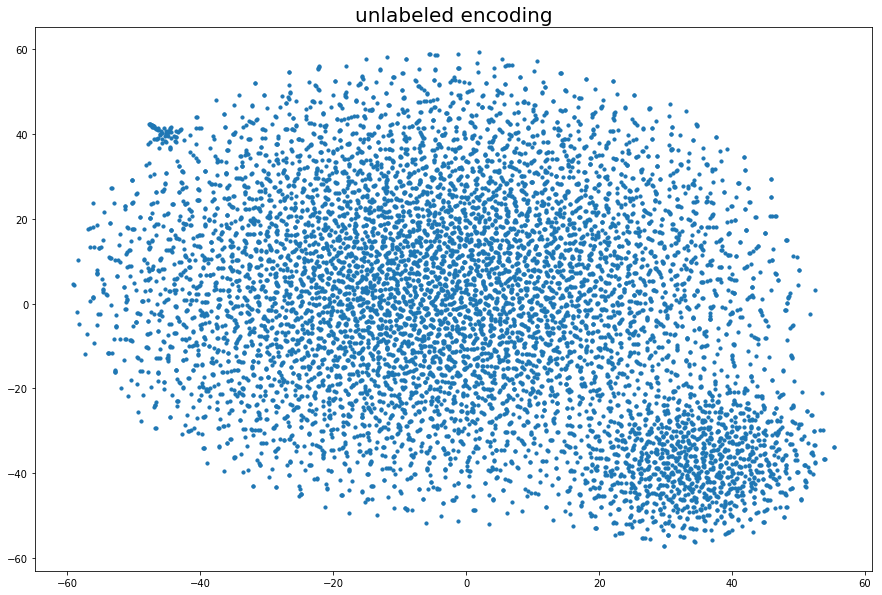

In [189]:
plot_tsne_df(tsne_df)

In [190]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [191]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [192]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [193]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,YHS,-1.766667,129.129967,19.333333,145.266667
1,XHD,-3.350000,126.113350,18.000000,132.150000
2,QRH,-3.733333,140.484733,22.000000,156.800000
3,VIY,2.466667,125.154000,21.666667,166.766667
4,NAF,0.366667,110.784800,17.666667,130.866667


In [194]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,YHS,-1.766667,129.129967,19.333333,145.266667,19.519281,-20.705189
1,XHD,-3.350000,126.113350,18.000000,132.150000,25.934887,-42.208248
2,QRH,-3.733333,140.484733,22.000000,156.800000,-23.555115,46.362495
3,VIY,2.466667,125.154000,21.666667,166.766667,-3.931910,-4.059210
4,NAF,0.366667,110.784800,17.666667,130.866667,13.280647,-10.856707


In [195]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

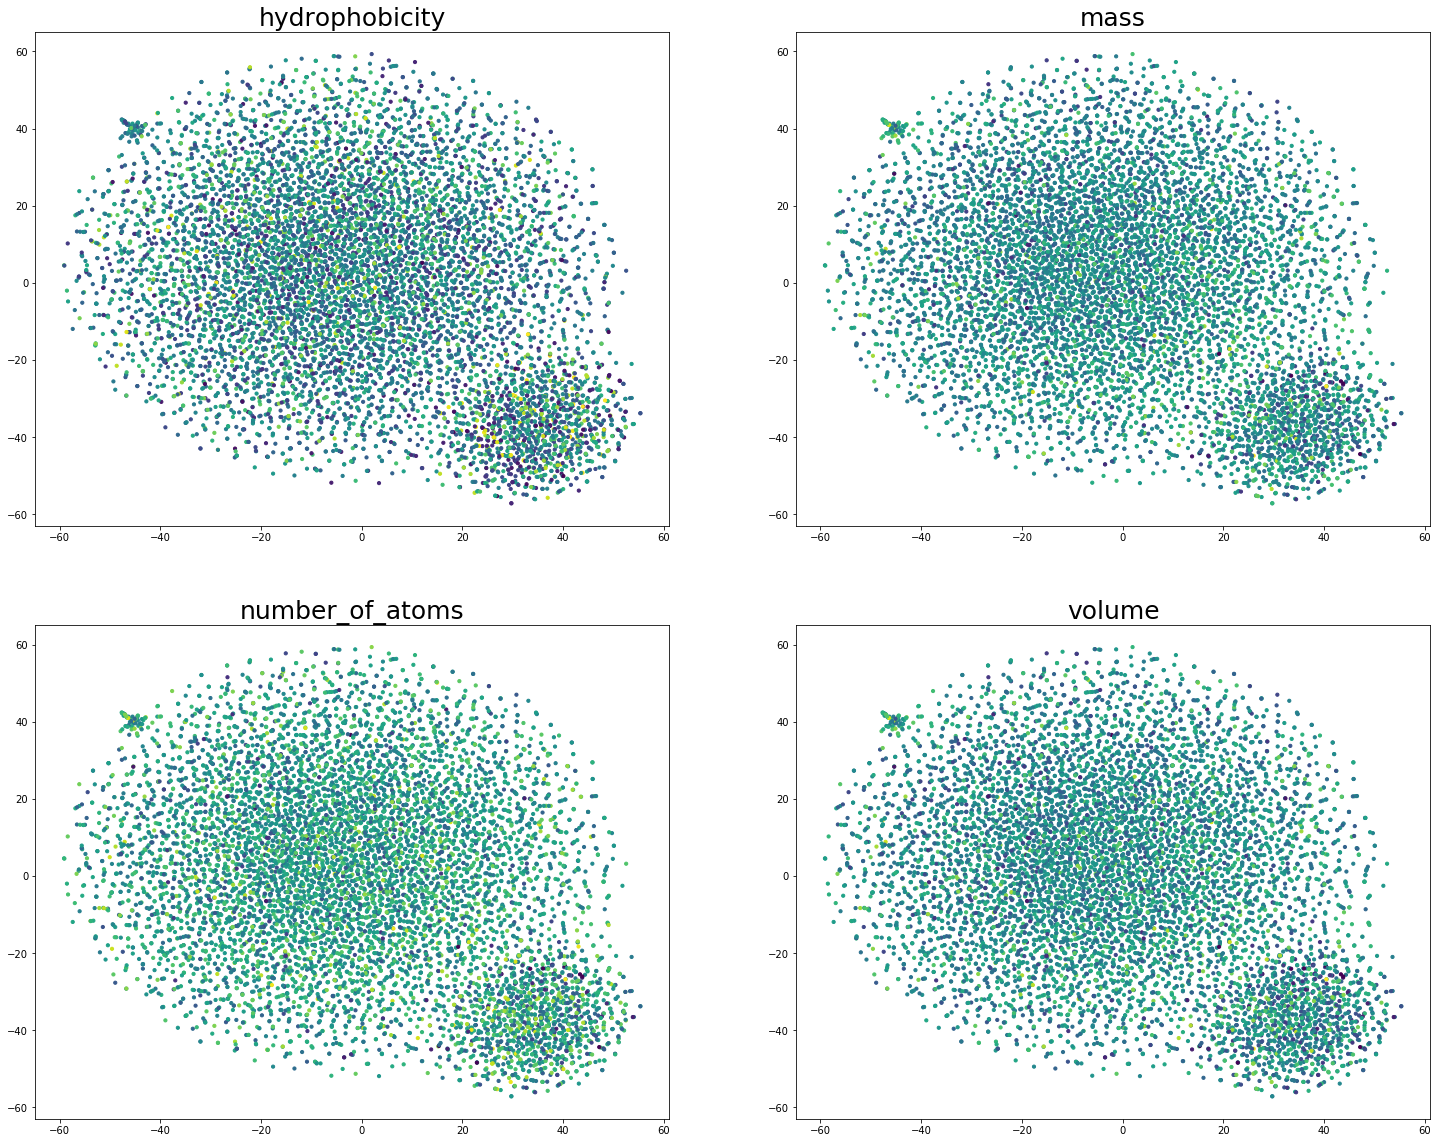

In [196]:
plot_embedding_properties(final_df)

In [198]:
writer = SummaryWriter('./tensor')
rev_dict = {val:key for key, val in dictionary.items()}
writer.add_embedding(model.embed_centres.weight, metadata=torch.randint(1, 10, (9424, )))
writer.close()